# Проект по А/B-тестированию

В нашем распоряжении данные с действиями пользователей, а также несколько вспомогательных датасетов, по которым необходимо провести оценку результатов А/В теста. Название теста: "recommender_system_test", он связан с введением новой рекомендательной системы.  
К набору новых пользователей на это тестирование предъявлены некоторые требования, указанные в техническом задании.  
Параллельно с этим тестированием проводился еще один тест под названием "interface_eu_test". Поэтому необходимо проверить тестовую выборку на пересечение с другим тестом, на соответствие техническому заданию, а также оценить корректность проведения теста.  
Введение новой рекомендательной системы будет считаться успешным, если за 14 дней с момента регистрации в системе конверсия пользователей из группы В в каждое из событий (product_page, product_cart, purchase) будет минимум на 10% выше, чем у пользователей из группы А.

**Данные**

/datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;  
_**Структура файла:**_
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

/datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;
_**Структура файла:**_
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

/datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;  
_**Структура файла:**_
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

/datasets/final_ab_participants.csv — таблица участников тестов.  
_**Структура файла:**_
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

**Цели исследования**  

1. С помощью имеющихся данных проверить выборку на соответствие требованиям ТЗ, оценить корректность проведения теста.
2. Сравнить тестовые группы между собой путем различных исследований и оценить, достигнут ли ожидаемый эффект.
3. Понять, оправдали ли себя изменения, связанные с внедрением улучшенной рекомендательной системы.

## Загрузка данных в переменные и просмотр информации

*Импорт библиотек*

In [38]:
import datetime as dt
import math as mth

import numpy as np
import pandas as pd
import plotly.figure_factory as ff

from matplotlib import pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st

*Запись данных в переменные*

In [39]:
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

*Функция для просмотра информации о датафрейме*

In [40]:
def inform(df):
    df.info()
    display(df.head(10))
    return 'Кол-во полных дубликатов:', df.duplicated().sum()

*Просмотр информации о таблице с событиями новых пользователей*

In [41]:
inform(events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


('Кол-во полных дубликатов:', 0)

*Просмотр информации о таблице с календарем маркетинговых событий*

In [42]:
inform(marketing_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


('Кол-во полных дубликатов:', 0)

*Просмотр информации о таблице с данными о новых пользователях*

In [43]:
inform(new_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


('Кол-во полных дубликатов:', 0)

*Просмотр информации о таблице с участниками тестов*

In [44]:
inform(participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


('Кол-во полных дубликатов:', 0)

*Просмотр столбца с регионами пользователей на предмет неявных дубликатов*

In [45]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

*Просмотр столбца с устройствами, с которых происходила регистрация, на предмет неявных дубликатов*

In [46]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

_**Дубликаты во всех таблицах отсутствуют. Пропущенные значения в столбце `details` таблицы `events` объясняются тем, что этот столбец заполняется только при совершении пользователем события `purchase`. Все столбцы с датами необходимо привести к типу datetime.**_

In [47]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')

_**Просмотр данных завершен, можно переходить к анализу.**_

## Оценка корректности проведения теста

### Анализ пересечений

In [48]:
print('Количество пользователей, участвующих в тесте "recommender_system_test":',
      participants.query('ab_test == "recommender_system_test"')['user_id'].nunique())

Количество пользователей, участвующих в тесте "recommender_system_test": 6701


*Проверка на пересечение с конкурирующим тестом*

In [49]:
print(
    'Кол-во пересечений с группой А теста "interface_eu_test":',
    len(
        set(
            participants
            .query('ab_test == "interface_eu_test" and group == "A"')
            ['user_id']
        ).intersection(
            set(
                participants
                .query('ab_test == "recommender_system_test"')
                ['user_id']
            )
        )
    )
)

for value in participants['group'].unique():
    print(f'Кол-во пересечений группы {value} с группой B теста "interface_eu_test":',
    len(
        set(
            participants
            .query('ab_test == "interface_eu_test" and group == "B"')
            ['user_id']
        ).intersection(
            set(
                participants
                .query('ab_test == "recommender_system_test" and group == @value')
                ['user_id']
            )
        )
    )
)

Кол-во пересечений с группой А теста "interface_eu_test": 819
Кол-во пересечений группы A с группой B теста "interface_eu_test": 439
Кол-во пересечений группы B с группой B теста "interface_eu_test": 344


_**С конкурирующим тестом пересекаются более 1600 пользователей, однако, убрать их возможности нет, т.к. тогда участников теста будет менее 6000.**_  
_**Пересечения с группой А конкурирующего теста смущать не должны, т.к. эти пользователи не видят изменений в рамках теста "interface_eu_test".**_  
_**Если бы в группу B теста "interface_eu_test" попало одинаковое количество пользователей из групп А и В теста "recommender_system_test", то можно было бы сказать, что он оказывает на обе группы одинаковое влияние, однако, величины групп различаются на 22%. Тем не менее, пока опрометчиво что-то делать с этими пользователями, необходимо продолжить анализ.**_

*Проверка на пересечение групп теста "recommender_system_test"*

In [50]:
print(
    'Кол-во пересечений групп теста "recommender_system_test":', 
    len(
      participants
      .query('ab_test == "recommender_system_test"')
      .groupby('user_id')
      .agg({'group': 'nunique'})
      .query('group > 1')
    )
)

Кол-во пересечений групп теста "recommender_system_test": 0


_**В рамках теста "recommender_system_test" тестовые группы не пересекаются.**_

*Распределение пользователей по группам*

In [51]:
participants.query('ab_test == "recommender_system_test"')['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

_**Выборки различаются на 25%.**_

*Проверка правильности формирования групп*

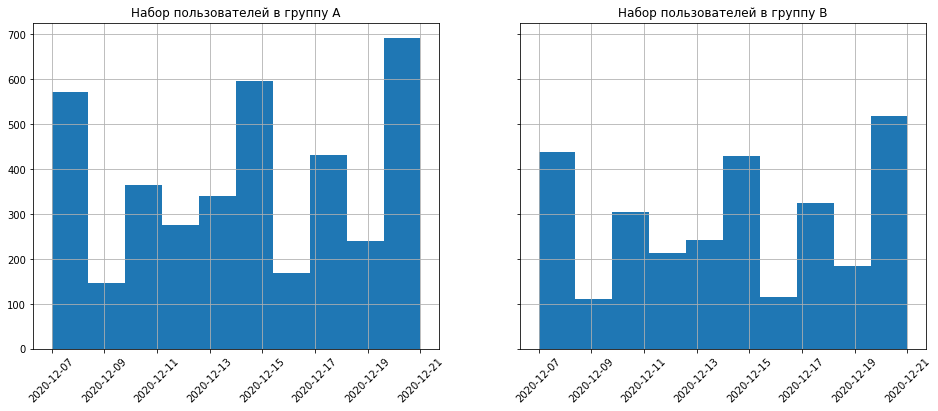

In [52]:
# создание ячеек для графиков
fig, ax = plt.subplots(1, 2, figsize = (16, 6), sharey=True)

for i, value in enumerate(participants['group'].unique()):
    
    # построение гистограмм
    ax[i].hist(
        participants
        .query('ab_test == "recommender_system_test" and group == @value')
        .merge(new_users, on='user_id', how='left')
        ['first_date']
    )
    ax[i].set_title(f'Набор пользователей в группу {value}')
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].grid();

_**Характер набора пользователей в обе группы теста примерно одинаковый.**_

### Проверка соответствия данных требованиям технического задания

*Сбор нового датафрейма для дальнейшего анализа*

In [53]:
test_data = (
    participants
    .query('ab_test == "recommender_system_test"')[['user_id', 'group']]
    .merge(new_users[['user_id', 'first_date', 'region']], on='user_id', how='left')
    .merge(events[['user_id', 'event_dt', 'event_name']], on='user_id', how='left')
)

test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27724 entries, 0 to 27723
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     27724 non-null  object        
 1   group       27724 non-null  object        
 2   first_date  27724 non-null  datetime64[ns]
 3   region      27724 non-null  object        
 4   event_dt    24698 non-null  datetime64[ns]
 5   event_name  24698 non-null  object        
dtypes: datetime64[ns](2), object(4)
memory usage: 1.5+ MB


,user_id,group,first_date,region,event_dt,event_name
0,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-07 14:43:27,purchase
1,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-25 00:04:56,purchase
2,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-07 14:43:29,product_cart
3,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-25 00:04:57,product_cart
4,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-07 14:43:27,product_page


_**Более трех тысяч пользователей зарегистрировались и попали в тестовые группы, но не совершали никаких событий.**_

In [54]:
print('Количество пользователей, попавших в тестирование и совершивших хотя бы одно событие:',
      test_data.query('event_name.notnull()', engine='python')['user_id'].nunique())

print('Распределение этих пользователей по группам:',
      test_data.query('event_name.notnull()', engine='python').groupby('group')['user_id'].nunique())

Количество пользователей, попавших в тестирование и совершивших хотя бы одно событие: 3675
Распределение этих пользователей по группам: group
A    2747
B     928
Name: user_id, dtype: int64


_**Распределение пользователей по группам стало еще более удручающим, теперь в группе А в 3 раза больше пользователей, чем в группе В.**_

*Проверка сроков набора новых пользователей*

In [55]:
print('Первый день набора пользователей', test_data['first_date'].min())
print('Последний день набора пользователей', test_data['first_date'].max())

Первый день набора пользователей 2020-12-07 00:00:00
Последний день набора пользователей 2020-12-21 00:00:00


_**Сроки набора совпадают с указананными в ТЗ.**_

*Проверка сроков тестирования*

In [56]:
print('Первый день тестирования', test_data['event_dt'].min())
print('Последний день тестирования', test_data['event_dt'].max())

Первый день тестирования 2020-12-07 00:05:57
Последний день тестирования 2020-12-30 12:42:57


_**Данные за 5 дней до предполагаемой остановки теста отсутствуют. То есть, некоторые пользователи не успели пробыть в тестировании 14 дней. Рассмотрим в дальнейшем, как их присутствие влияет на конверсию.**_

*Проверка доли новых пользователей из EU*

In [57]:
print('Доля новых пользователей из региона EU, попавших в тестирование:',
     test_data
      .query('region == "EU"')
      ['user_id']
      .nunique()
      /
     new_users
    .loc[
        (new_users['first_date'] > test_data['first_date'].min()) & 
         (new_users['first_date'] < test_data['first_date'].max()) & 
         (new_users['region'] == 'EU')
    ]
      ['user_id']
      .nunique()
     )

Доля новых пользователей из региона EU, попавших в тестирование: 0.18966701508137973


_**В тестирование попало 19% новых пользователей, пришедших из региона EU. Это соответствует требованию технического задания.**_  

*Т.к. ожидаемый эффект рассчитывается за 14 дней с момента регистрации пользователя, необходимо удалить события, которые пользователь совершил на 15й день и позднее.*  

*Добавление столбца с кол-вом дней от регистрации до совершения события*

In [58]:
test_data['days_reg_event'] = (test_data['event_dt'] - test_data['first_date']).dt.days

test_data.head()

,user_id,group,first_date,region,event_dt,event_name,days_reg_event
0,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-07 14:43:27,purchase,0.0
1,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-25 00:04:56,purchase,18.0
2,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-07 14:43:29,product_cart,0.0
3,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-25 00:04:57,product_cart,18.0
4,D1ABA3E2887B6A73,A,2020-12-07,EU,2020-12-07 14:43:27,product_page,0.0


*Удаление событий, превышающих 14 дней*

In [59]:
test_data = test_data.query('days_reg_event < 15')

*Необходимо также убрать пользователей, не совершивших за период тестирования ни одного события. На них необходимо было проверить соответствие тестовой группы ТЗ, но для анализа А/В теста нужно оперировать именно событиями, так что эти пользователи в дальнейшем неинтересны.*

In [60]:
test_data = test_data.query('event_name.notnull()', engine='python')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24070 entries, 0 to 27723
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         24070 non-null  object        
 1   group           24070 non-null  object        
 2   first_date      24070 non-null  datetime64[ns]
 3   region          24070 non-null  object        
 4   event_dt        24070 non-null  datetime64[ns]
 5   event_name      24070 non-null  object        
 6   days_reg_event  24070 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 1.5+ MB


*Еще раз проверим распределение пользователей по группам*

In [61]:
print('Количество пользователей, попавших в тестирование и совершивших хотя бы одно событие:',
      test_data['user_id'].nunique())

print('Распределение этих пользователей по группам:',
      test_data.groupby('group')['user_id'].nunique())

Количество пользователей, попавших в тестирование и совершивших хотя бы одно событие: 3675
Распределение этих пользователей по группам: group
A    2747
B     928
Name: user_id, dtype: int64


_**Количество пользователей в группах осталось прежним. Датафрейм для дальнейшего анализа сформирован.**_

### Анализ времени проведения теста на предмет совпадения с маркетинговыми и другими активностями

*Добавление новой строки в таблицу с маркетинговыми событиями*

In [62]:
marketing_events.loc[len(marketing_events.index)] = [
    'Recommender system test', 
    'EU, CIS, APAC, N.America', 
    '2020-12-07',
    '2021-01-04'
]
marketing_events.tail()

,name,regions,start_dt,finish_dt
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
14,Recommender system test,"EU, CIS, APAC, N.America",2020-12-07,2021-01-04


*Построение диаграммы Ганта*

In [63]:
marketing_events.set_axis(['Task', 'regions', 'Start', 'Finish'], axis='columns', inplace=True)

fig = ff.create_gantt(marketing_events[['Task', 'Start', 'Finish']])
fig.show();

_**С нашим тестом пересекаются рекламные кампании "CIS New Year Gift Lottery" и "Christmas&New Year Promo". Они начались уже после окончания набора новых пользователей в тестирование. Однако, если они анонсировались заранее, то могли повлиять как на приход новых пользователей, так и на совершение этими пользователями определенных событий.**_

## Исследовательский анализ данных

### Количество событий на пользователя в выборках

*Распределение кол-ва событий на пользователя в разрезе по событиям*

In [64]:
events_per_user = (
    test_data
    .groupby(['user_id', 'group', 'event_name'])
    ['event_dt']
    .count()
    .reset_index()
)

events_per_user.groupby(['group', 'event_name']).agg({'event_dt':'describe'})

event_dt                                             
                      count      mean       std  min  25%  50%  75%  max
group event_name                                                        
A     login          2747.0  3.057881  1.211410  1.0  2.0  3.0  4.0  7.0
      product_cart    824.0  3.057039  1.183277  1.0  2.0  3.0  4.0  7.0
      product_page   1780.0  3.042135  1.223675  1.0  2.0  3.0  4.0  7.0
      purchase        872.0  2.996560  1.197486  1.0  2.0  3.0  4.0  7.0
B     login           927.0  2.689320  1.228058  1.0  2.0  3.0  3.0  8.0
      product_cart    255.0  2.584314  1.206833  1.0  2.0  2.0  3.0  8.0
      product_page    523.0  2.544933  1.192002  1.0  2.0  2.0  3.0  8.0
      purchase        256.0  2.500000  1.204566  1.0  2.0  2.0  3.0  7.0

_**Вплоть до третьего квартиля, а также по средним показателям группа А превосходит группу В по количеству совершенных событий на пользователя. Но максимальное кол-во событий, совершенных пользователями, больше у группы В.**_

### Распределение количества событий в выборках по дням

*Построение графика распределения количества событий*

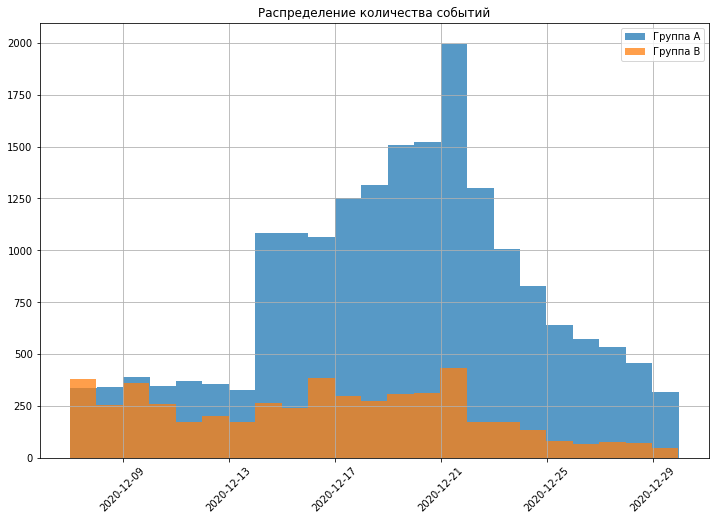

In [65]:
plt.figure(figsize=(12, 8))
plt.hist(test_data.query('group == "A"')['event_dt'], bins=23, alpha=0.75, label='Группа А')
plt.hist(test_data.query('group == "B"')['event_dt'], bins=23, alpha=0.75, label='Группа В')

plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.title('Распределение количества событий')
plt.grid()
plt.show()

_**Пользователи из группы В поначалу идут вровень с пользователями из группы А, но уже начиная с пятого дня, отстают все больше и больше. В обеих группах с 14 декабря идет прирост количества событий, а с 22 декабря резкий спад.**_

*Построение графика среднего количества событий в день на пользователя*

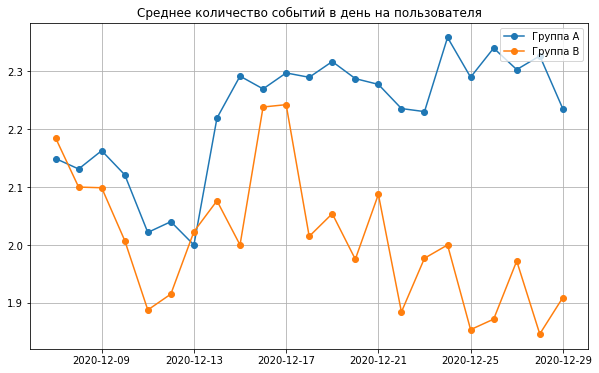

In [66]:
# добавление столбца с датой события
test_data['event_date'] = test_data['event_dt'].dt.date

# создание таблицы с кол-вом событий и пользователей за день
mean_events_date_user = (
    test_data
    .groupby(['group', 'event_date'])
    .agg({'event_name':'count', 'user_id':'nunique'})
    .reset_index()
)

# добавление столбца со средним кол-вом событий на пользователя
mean_events_date_user['mean_events_date_user'] = (
    mean_events_date_user['event_name'] /
    mean_events_date_user['user_id']
)

# построение графика
plt.figure(figsize=(10, 6))
for value in mean_events_date_user['group'].unique():
    plt.plot(
        mean_events_date_user.query('group == @value')['event_date'],
        mean_events_date_user.query('group == @value')['mean_events_date_user'],
        '-o',
        label=f'Группа {value}'
    )

plt.legend(loc='upper right')
plt.title('Cреднее количество событий в день на пользователя')
plt.grid()
plt.show()

_**В группе А среднее количество событий в день на пользователя со временем устанавливается, в то время как в группе В оно снижается. Группа А опережает группу В.**_

### Изменение конверсии в воронке в выборках на разных этапах

*Построение воронки*

In [67]:
# создание сводной таблицы
funnel = (
    test_data
    .pivot_table(
        index='event_name', 
        columns='group', 
        values='user_id', 
        aggfunc='nunique'
    ).reset_index()
)
    
# расстановка строк согласно воронке событий
funnel = funnel.reindex([0, 2, 1, 3])

# добавление столбцов с долями от общего кол-ва пользователей в группах
for value in test_data['group'].unique():

    funnel[f'share_of_initial_{value}'] = (
        funnel[value] / test_data.query('group == @value')['user_id'].nunique()
    ).round(3)

# добавление столбца с относительной разницей между группами
funnel['A_B_difference'] = funnel['share_of_initial_B'] - funnel['share_of_initial_A']

funnel

group,event_name,A,B,share_of_initial_A,share_of_initial_B,A_B_difference
0,login,2747,927,1.000,0.999,-0.001
2,product_page,1780,523,0.648,0.564,-0.084
1,product_cart,824,255,0.300,0.275,-0.025
3,purchase,872,256,0.317,0.276,-0.041


*Визуализация воронки*

In [68]:
fig = go.Figure()

for value in test_data['group'].unique():

    fig.add_trace(go.Funnel(
        name = f'Группа {value}',
        y = funnel['event_name'],
        x = funnel[value],
        textinfo = "value+percent initial"))

fig.show()

_**Конверсия в просмотр карточек товаров составила 65% для группы А и 56% для группы В. Конверсия в просмотры корзины и покупки внутри групп практически одинакова и составляет 30% и 32% соответственно для группы А и по 28% для группы В.**_

*Уберем пользователей, пришедших 16 декабря 2020г и позже. Оценим конверсию пользователей, которые оставались в тестировании 14 дней*

In [69]:
two_weeks_only_users = test_data.loc[test_data['first_date'] < dt.datetime(2020, 12, 16)]
two_weeks_only_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11270 entries, 0 to 27723
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         11270 non-null  object        
 1   group           11270 non-null  object        
 2   first_date      11270 non-null  datetime64[ns]
 3   region          11270 non-null  object        
 4   event_dt        11270 non-null  datetime64[ns]
 5   event_name      11270 non-null  object        
 6   days_reg_event  11270 non-null  float64       
 7   event_date      11270 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 792.4+ KB


In [70]:
print('Количество пользователей, "проживших" в тестировании 14 дней:',
      two_weeks_only_users['user_id'].nunique())

print('Распределение этих пользователей по группам:',
      two_weeks_only_users.groupby('group')['user_id'].nunique())

Количество пользователей, "проживших" в тестировании 14 дней: 1753
Распределение этих пользователей по группам: group
A    1216
B     537
Name: user_id, dtype: int64


_**Отсеялось больше половины пользователей. В группе А теперь в 2,3 раза больше пользователей, чем в группе В.**_

*Построение воронки*

In [71]:
# создание сводной таблицы
two_weeks_funnel = (
    two_weeks_only_users
    .pivot_table(
        index='event_name', 
        columns='group', 
        values='user_id', 
        aggfunc='nunique'
    ).reset_index()
)
    
# расстановка строк согласно воронке событий
two_weeks_funnel = two_weeks_funnel.reindex([0, 2, 1, 3])

# добавление столбцов с долями от общего кол-ва пользователей в группах
for value in two_weeks_only_users['group'].unique():
    two_weeks_funnel[f'share_of_initial_{value}'] = (
        two_weeks_funnel[value] / 
        two_weeks_only_users
        .query('group == @value')
        ['user_id']
        .nunique()
    ).round(3)

# добавление столбца с относительной разницей между группами
two_weeks_funnel['A_B_difference'] = (
    two_weeks_funnel['share_of_initial_B'] - 
    two_weeks_funnel['share_of_initial_A']
)

two_weeks_funnel

group,event_name,A,B,share_of_initial_A,share_of_initial_B,A_B_difference
0,login,1216,536,1.000,0.998,-0.002
2,product_page,765,299,0.629,0.557,-0.072
1,product_cart,354,135,0.291,0.251,-0.040
3,purchase,350,145,0.288,0.270,-0.018


*Визуализация воронки*

In [72]:
fig = go.Figure()

for value in two_weeks_only_users['group'].unique():
    fig.add_trace(go.Funnel(
        name = f'Группа {value}',
        y = two_weeks_funnel['event_name'],
        x = two_weeks_funnel[value],
        textinfo = "value+percent initial"))

fig.show()

_**После удаления пользователей конверсия в воронке изменилась в пределах 2%. Значит пользователи, которые не успели провести 14 дней в тестировании, практически не влияют на конверсию. Можно не исключать их.**_

### Особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию

1. Неравномерное распределение пользователей по группам. В группе А практически в 3 раза больше пользователей, чем в группе В.
2. Из 6701 пользователя, набранных в тестирование, только 3675 совершили как минимум 1 событие в рамках теста. 
3. Более половины пользователей, совершивших как минимум 1 событие, не успели принять участие в тестировании на протяжении 14 дней.

## Оценка результатов A/B-тестирования

### Результаты A/В-тестирования

Разница в конверсии между группами на этапах воронки составила от 2,5% до 8,4% в пользу группы А. Это говорит о том, что ожидаемый эффект улучшения каждой метрики не менее, чем на 10% за 14 дней с момента регистрации, не только не был достигнут, группа В даже показала худшую конверсию на всех этапах, чем группа А.

### Проверка статистической разницы долей z-критерием

_**Нулевая гипотеза**_   
*Статистически значимого различия между группами А/В теста нет.*

_**Альтернативная гипотеза**_   
*Статистически значимое различие между группами А/В теста есть.*

In [73]:
# создание функции для подсчета критерия статистического отличия между группами

def z_test(column_1, column_2, group_1, group_2, alpha = .05):
    
    successes = np.array([column_1, 
                          column_2])
    
    trials = np.array([test_data.query('group == @group_1')['user_id'].nunique(),
                       test_data.query('group == @group_2')['user_id'].nunique()])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # подсчет статистики в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задание стандартного нормального распределения (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = ((1 - distr.cdf(abs(z_value))) * 2).round(3)

    if p_value < alpha:
        return f'{p_value}, Стат. разл. есть'
    else:
        return f'{p_value}, Стат. разл. нет'

*Т.к. в этом случае проводится множественная проверка гипотез, необходимо применить поправку Бонферрони. Разделим стандартное значение уровня критической значимости alpha равное 5% на количество проводимых исследований, то есть на 3.*

In [74]:
# запись в таблицу результата теста
funnel['a_b_p_value'] = funnel.apply(
    lambda row: z_test(row['A'], row['B'], 'A', 'B', alpha=0.05 / 3), axis=1)

funnel

group,event_name,A,B,share_of_initial_A,share_of_initial_B,A_B_difference,a_b_p_value
0,login,2747,927,1.000,0.999,-0.001,"0.085, Стат. разл. нет"
2,product_page,1780,523,0.648,0.564,-0.084,"0.0, Стат. разл. есть"
1,product_cart,824,255,0.300,0.275,-0.025,"0.145, Стат. разл. нет"
3,purchase,872,256,0.317,0.276,-0.041,"0.018, Стат. разл. нет"


_**Группы статистически различаются только на этапе конверсии в просмотр карточек товаров. На остальных этапах статистически значимого различия между группами тестирования нет.**_

## Вывод

В ходе оценки корректности проведения А/В тестирования выяснено следующее:
1. В тестирование набран 6701 пользователь.
2. В группу A набрано 3824 пользователя, в группу B 2877 пользователей, таким образом, выборки различаются на 25%.
3. 1602 пользователя также параллельно принимали участие в другом тестировании.
4. 3675 пользователей из участников теста совершили хотя бы одно событие в рамках тестирования.
5. Из них в группу А попало 2747 пользователей, в группу B 928 пользователей, таким образом, выборки различаются на 66%.
6. Из пользователей, совершивших хотя бы 1 событие, 1753 пользователя успели принять участие в тестировании на протяжении 14 дней.
7. Параллельно с тестированием проводились 2 маркетинговые компании.

Таким образом, были нарушены как правила проведения А/В тестов, так и требования технического задания.

Тем не менее, оценка результатов тестирования была проведена.

На всех этапах воронки группа В показала худшую конверсию, чем группа А (разница от 2,5% до 8,4% на разных этапах).  
Ожидаемый эффект, что за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%, не достигнут.

Статистический тест показал различие между тестовыми группами только на этапе конверсии в просмотр карточек товаров. На этапах просмотра корзины и покупок статистически значимого различия между группами тестирования нет.

Таким образом, можно заключить, что изменения, связанные с внедрением улучшенной рекомендательной системы, не дали ожидаемого эффекта.

Однако, принимая во внимание многочисленные нарушения в процессе набора пользователей и нарушения сроков тестирования, рекомендую повторить данный тест, внимательнее отнесясь к набору пользователей в тестовые выборки.  
Необходимо набирать разных пользователей на разные тесты, а также равномерно заполнять пользователями группы внутри текущего теста. Не прерывать сбор данных, пока все пользователя не "прожили" сроки тестирования.  
Также лучше набирать на тест пользователей, которые с большей вероятностью будут совершать события после регистрации. Возможно сделать это с помощью дополнительного анализа, оценить, например, пользователи из какого региона и зарегистрировавшиеся с каких устройтсв, закрепляются лучше.